## Cloth Classification using CNN by Transfer Learning

### import packages

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img,ImageDataGenerator
from tensorflow.keras.applications.xception import Xception,preprocess_input,decode_predictions
import matplotlib.pyplot as plt

2025-07-17 16:57:03.317541: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-17 16:57:03.333334: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-17 16:57:03.357733: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-17 16:57:03.357771: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-17 16:57:03.372994: I tensorflow/core/platform/cpu_feature_gua

### Create Data generators

In [4]:
train_gen = ImageDataGenerator(preprocessing_function = preprocess_input)
val_gen = ImageDataGenerator(preprocessing_function = preprocess_input)
test_gen = ImageDataGenerator(preprocessing_function = preprocess_input)
train_data = train_gen.flow_from_directory('clothing-dataset-small-master/train',target_size = (150,150),batch_size = 32)
val_data = val_gen.flow_from_directory('clothing-dataset-small-master/validation',target_size = (150,150),batch_size = 32,shuffle = False)
test_data = test_gen.flow_from_directory('clothing-dataset-small-master/test',target_size = (150,150),batch_size = 32,shuffle = False)

Found 3068 images belonging to 10 classes.
Found 341 images belonging to 10 classes.
Found 372 images belonging to 10 classes.


In [5]:
train_data.class_indices

{'dress': 0,
 'hat': 1,
 'longsleeve': 2,
 'outwear': 3,
 'pants': 4,
 'shirt': 5,
 'shoes': 6,
 'shorts': 7,
 'skirt': 8,
 't-shirt': 9}

In [6]:
X,y = next(train_data)
X.shape

(32, 150, 150, 3)

### Initialize Pre-trained Xception Model

In [18]:
base_model = Xception(weights = 'imagenet',input_shape = (150,150,3),include_top = False)
base_model.trainable = False

2025-07-17 09:07:24.109029: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


### Train the Model

In [25]:
learning_rate = 0.01
inputs = keras.Input(shape = (150,150,3))
base_features = base_model(inputs,training = False)
feature_vectors = keras.layers.GlobalAveragePooling2D()(base_features)
optimizer = keras.optimizers.Adam(learning_rate = learning_rate)
loss = keras.losses.CategoricalCrossentropy(from_logits = True)
outputs = keras.layers.Dense(10)(feature_vectors)
model = keras.Model(inputs,outputs)
model.compile(optimizer=optimizer,loss=loss,metrics = ['accuracy'])
history = model.fit(train_data,epochs = 10,validation_data = val_data)

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 94s 955ms/step - accuracy: 0.5837 - loss: 1.5419 - val_accuracy: 0.7625 - val_loss: 0.9005
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 90s 937ms/step - accuracy: 0.8160 - loss: 0.5905 - val_accuracy: 0.7683 - val_loss: 0.8841
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 90s 940ms/step - accuracy: 0.8798 - loss: 0.3334 - val_accuracy: 0.7889 - val_loss: 0.9198
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 141s 934ms/step - accuracy: 0.8924 - loss: 0.3019 - val_accuracy: 0.7801 - val_loss: 1.0672
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 90s 933ms/step - accuracy: 0.9068 - loss: 0.2616 - val_accuracy: 0.7889 - val_loss: 1.0061
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 90s 934ms/step - accuracy: 0.9640 - loss: 0.1095 - val_accuracy: 0.7859 - val_loss: 0.8550
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 91s 952ms/step - accuracy: 0.9778 - loss: 0.0771 - val_accuracy: 0.8182 - val_loss: 0.8604
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 90s 935ms/step - accuracy: 0.9901 - loss: 0.0489 - val_acc

### Analyze the accuracy curves

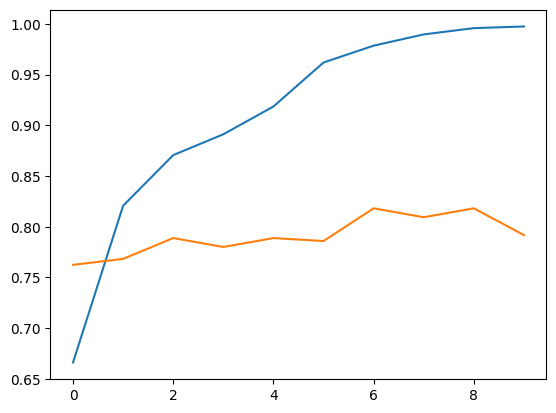

In [28]:
plt.plot(history.history['accuracy'],label = 'train')
plt.plot(history.history['val_accuracy'],label = 'val')

### Tune the Hyperparameters

### Learning Rate

In [7]:
def create_model(learning_rate = 0.01):
    base_model = Xception(weights = 'imagenet',input_shape = (150,150,3),include_top = False)
    base_model.trainable = False
    inputs = keras.Input(shape = (150,150,3))
    base_features = base_model(inputs,training = False)
    feature_vectors = keras.layers.GlobalAveragePooling2D()(base_features)
    optimizer = keras.optimizers.Adam(learning_rate = learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits = True)
    outputs = keras.layers.Dense(10)(feature_vectors)
    model = keras.Model(inputs,outputs)
    model.compile(optimizer=optimizer,loss=loss,metrics = ['accuracy'])
    return model

In [8]:
scores = {}
for lr in [0.001,0.01,0.1,1]:
    print(lr)
    model = create_model(learning_rate = lr)
    history = model.fit(train_data,epochs = 10,validation_data = val_data)
    scores[lr] = history.history
    print()
    print()

0.001


2025-07-17 14:50:42.147251: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-07-17 14:50:45.659533: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-07-17 14:50:45.663687: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

83683744/83683744 [==============================] - 0s 0us/step
Epoch 1/10


2025-07-17 14:51:12.228323: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1752763887.463796   14174 service.cc:145] XLA service 0x7f6a48d3d920 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752763887.463834   14174 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2025-07-17 14:51:27.800762: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


 1/96 [..............................] - ETA: 1:02:12 - loss: 2.2974 - accuracy: 0.1562

I0000 00:00:1752763888.461646   14174 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


96/96 [==============================] - 52s 137ms/step - loss: 1.0672 - accuracy: 0.6333 - val_loss: 0.6988 - val_accuracy: 0.7918
Epoch 2/10
96/96 [==============================] - 6s 63ms/step - loss: 0.6283 - accuracy: 0.7878 - val_loss: 0.6432 - val_accuracy: 0.7947
Epoch 3/10
96/96 [==============================] - 6s 63ms/step - loss: 0.5044 - accuracy: 0.8308 - val_loss: 0.5796 - val_accuracy: 0.8123
Epoch 4/10
96/96 [==============================] - 6s 63ms/step - loss: 0.4290 - accuracy: 0.8660 - val_loss: 0.5799 - val_accuracy: 0.8211
Epoch 5/10
96/96 [==============================] - 6s 66ms/step - loss: 0.3757 - accuracy: 0.8859 - val_loss: 0.5304 - val_accuracy: 0.8299
Epoch 6/10
96/96 [==============================] - 6s 64ms/step - loss: 0.3203 - accuracy: 0.9094 - val_loss: 0.5457 - val_accuracy: 0.8240
Epoch 7/10
96/96 [==============================] - 6s 65ms/step - loss: 0.2854 - accuracy: 0.9247 - val_loss: 0.5367 - val_accuracy: 0.8240
Epoch 8/10
96/96 [====

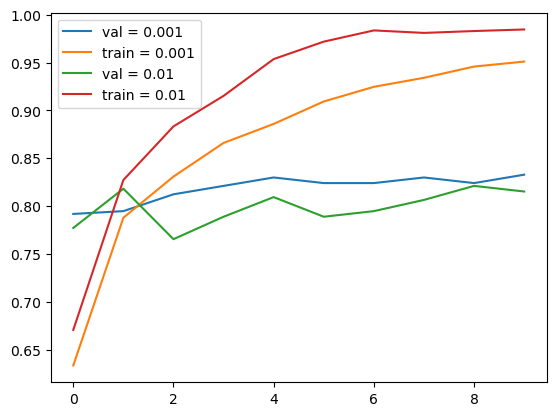

In [16]:
del scores[0.1]
for i,hist in scores.items():
    plt.plot(hist['val_accuracy'],label = f'val = {i}')
    plt.plot(hist['accuracy'],label = f'train = {i}')
    plt.legend()

#### we can fix lr = 0.001 for 2 reasons:
* The distance between train and validation curves are closer
* validation accuracy is higher than lr = 0.01

### No of nodes in inner dense layer

In [17]:
def create_model(learning_rate,inner_nodes):
    base_model = Xception(weights = 'imagenet',input_shape = (150,150,3),include_top = False)
    base_model.trainable = False
    inputs = keras.Input(shape = (150,150,3))
    base_features = base_model(inputs,training = False)
    feature_vectors = keras.layers.GlobalAveragePooling2D()(base_features)
    optimizer = keras.optimizers.Adam(learning_rate = learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits = True)
    inner = keras.layers.Dense(inner_nodes,activation = 'relu')(feature_vectors)
    outputs = keras.layers.Dense(10)(inner)
    model = keras.Model(inputs,outputs)
    model.compile(optimizer=optimizer,loss=loss,metrics = ['accuracy'])
    return model

In [18]:
scores = {}
lr = 0.001
for n in [10,100,1000]:
    print(n)
    model = create_model(learning_rate = lr,inner_nodes = n)
    history = model.fit(train_data,epochs = 10,validation_data = val_data)
    scores[n] = history.history
    print()
    print()

10
Epoch 1/10
96/96 [==============================] - 18s 103ms/step - loss: 1.5089 - accuracy: 0.5212 - val_loss: 1.1408 - val_accuracy: 0.6070
Epoch 2/10
96/96 [==============================] - 6s 64ms/step - loss: 0.9623 - accuracy: 0.6943 - val_loss: 0.8799 - val_accuracy: 0.7331
Epoch 3/10
96/96 [==============================] - 6s 65ms/step - loss: 0.7092 - accuracy: 0.7712 - val_loss: 0.7333 - val_accuracy: 0.7977
Epoch 4/10
96/96 [==============================] - 6s 66ms/step - loss: 0.5864 - accuracy: 0.8106 - val_loss: 0.6705 - val_accuracy: 0.7947
Epoch 5/10
96/96 [==============================] - 6s 64ms/step - loss: 0.5112 - accuracy: 0.8377 - val_loss: 0.6837 - val_accuracy: 0.7947
Epoch 6/10
96/96 [==============================] - 6s 64ms/step - loss: 0.4426 - accuracy: 0.8572 - val_loss: 0.6467 - val_accuracy: 0.8152
Epoch 7/10
96/96 [==============================] - 6s 64ms/step - loss: 0.3890 - accuracy: 0.8774 - val_loss: 0.6261 - val_accuracy: 0.8211
Epoch 8/

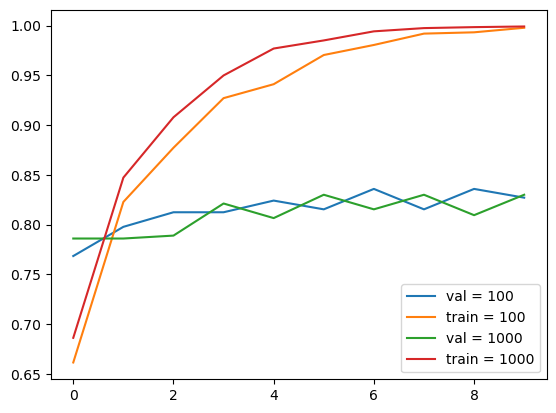

In [27]:
del scores[10]
for i,hist in scores.items():
    plt.plot(hist['val_accuracy'],label = f'val = {i}')
    plt.plot(hist['accuracy'],label = f'train = {i}')
    #plt.yticks([0.82,0.83,0.85,0.9])
    plt.legend()

#### There is not much of a difference between the two, but we can stick with 100 nodes because the validation accuracy is almost the same at a reduced computational cost

### Regularization

In [28]:
def create_model(learning_rate,inner_nodes,dropout_rate):
    base_model = Xception(weights = 'imagenet',input_shape = (150,150,3),include_top = False)
    base_model.trainable = False
    inputs = keras.Input(shape = (150,150,3))
    base_features = base_model(inputs,training = False)
    feature_vectors = keras.layers.GlobalAveragePooling2D()(base_features)
    optimizer = keras.optimizers.Adam(learning_rate = learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits = True)
    inner = keras.layers.Dense(inner_nodes,activation = 'relu')(feature_vectors)
    dropout = keras.layers.Dropout(dropout_rate)(inner)
    outputs = keras.layers.Dense(10)(dropout)
    model = keras.Model(inputs,outputs)
    model.compile(optimizer=optimizer,loss=loss,metrics = ['accuracy'])
    return model

In [32]:
scores = {}
lr = 0.001
n = 100
for r in [0.0,0.2,0.5,0.8]:
    print(r)
    model = create_model(learning_rate = lr,inner_nodes = n,dropout_rate = r)
    history = model.fit(train_data,epochs = 30,validation_data = val_data)
    scores[r] = history.history
    print()
    print()

0.0
Epoch 1/30
96/96 [==============================] - 18s 100ms/step - loss: 0.9646 - accuracy: 0.6802 - val_loss: 0.6291 - val_accuracy: 0.7713
Epoch 2/30
96/96 [==============================] - 6s 64ms/step - loss: 0.5209 - accuracy: 0.8142 - val_loss: 0.5455 - val_accuracy: 0.7918
Epoch 3/30
96/96 [==============================] - 6s 64ms/step - loss: 0.3535 - accuracy: 0.8833 - val_loss: 0.5387 - val_accuracy: 0.8094
Epoch 4/30
96/96 [==============================] - 6s 64ms/step - loss: 0.2536 - accuracy: 0.9198 - val_loss: 0.5720 - val_accuracy: 0.8094
Epoch 5/30
96/96 [==============================] - 6s 64ms/step - loss: 0.1889 - accuracy: 0.9472 - val_loss: 0.5177 - val_accuracy: 0.8387
Epoch 6/30
96/96 [==============================] - 6s 65ms/step - loss: 0.1277 - accuracy: 0.9723 - val_loss: 0.5539 - val_accuracy: 0.8387
Epoch 7/30
96/96 [==============================] - 6s 64ms/step - loss: 0.0872 - accuracy: 0.9844 - val_loss: 0.5767 - val_accuracy: 0.8240
Epoch 8

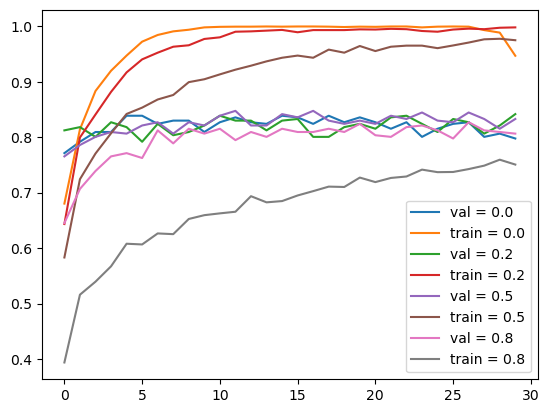

In [42]:
for i,hist in scores.items():
    plt.plot(hist['val_accuracy'],label = f'val = {i}')
    plt.plot(hist['accuracy'],label = f'train = {i}')
    #plt.yticks([0.82,0.83,0.85,0.9])
    plt.legend()

#### Dropout can be fixed at 0.5 since:
* 0 and 0.2 dropout rates training accuracy curves are very close to 1 from epoch 12. This indicates the model is overfitting.
* 0.8 training accuracy curve achieves very poor accuracy. Further the validation accuracy for 0.8 is so high than training
* The distance between the train and validation curves of 0.5 dropout rate is less compared to others and the trainng curve improves progressively and feels like it doesn't overfit 

### Data Augmentation

In [44]:
train_gen = ImageDataGenerator(preprocessing_function = preprocess_input,
                              vertical_flip = True,
                              shear_range = 10,
                              zoom_range = 0.1)
val_gen = ImageDataGenerator(preprocessing_function = preprocess_input)
test_gen = ImageDataGenerator(preprocessing_function = preprocess_input)
train_data = train_gen.flow_from_directory('clothing-dataset-small-master/train',target_size = (150,150),batch_size = 32)
val_data = val_gen.flow_from_directory('clothing-dataset-small-master/validation',target_size = (150,150),batch_size = 32,shuffle = False)
test_data = test_gen.flow_from_directory('clothing-dataset-small-master/test',target_size = (150,150),batch_size = 32,shuffle = False)

Found 3068 images belonging to 10 classes.
Found 341 images belonging to 10 classes.
Found 372 images belonging to 10 classes.


In [48]:
def create_model(learning_rate,inner_nodes,dropout_rate):
    base_model = Xception(weights = 'imagenet',input_shape = (150,150,3),include_top = False)
    base_model.trainable = False
    inputs = keras.Input(shape = (150,150,3))
    base_features = base_model(inputs,training = False)
    feature_vectors = keras.layers.GlobalAveragePooling2D()(base_features)
    optimizer = keras.optimizers.Adam(learning_rate = learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits = True)
    inner = keras.layers.Dense(inner_nodes,activation = 'relu')(feature_vectors)
    dropout = keras.layers.Dropout(dropout_rate)(inner)
    outputs = keras.layers.Dense(10)(dropout)
    model = keras.Model(inputs,outputs)
    model.compile(optimizer=optimizer,loss=loss,metrics = ['accuracy'])
    return model

In [49]:
save_checkpoint = keras.callbacks.ModelCheckpoint('xception_v_mini_{epoch:02d}_{val_accuracy:.3f}.h5',
                                                  save_best_only = True,
                                                  monitor = 'val_accuracy',
                                                  mode = 'max'
                                                 )

In [50]:
lr = 0.001
n = 100
r = 0.5
model = create_model(learning_rate = lr,inner_nodes = n, dropout_rate = r)
history = model.fit(train_data,epochs = 50,validation_data = val_data, callbacks = [save_checkpoint])

Epoch 1/50
96/96 [==============================] - ETA: 0s - loss: 1.5588 - accuracy: 0.4840

/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


96/96 [==============================] - 31s 236ms/step - loss: 1.5588 - accuracy: 0.4840 - val_loss: 0.9375 - val_accuracy: 0.6891
Epoch 2/50
96/96 [==============================] - 19s 196ms/step - loss: 1.1387 - accuracy: 0.6219 - val_loss: 0.7854 - val_accuracy: 0.7595
Epoch 3/50
96/96 [==============================] - 19s 193ms/step - loss: 0.9958 - accuracy: 0.6682 - val_loss: 0.7580 - val_accuracy: 0.7537
Epoch 4/50
96/96 [==============================] - 19s 197ms/step - loss: 0.9183 - accuracy: 0.6855 - val_loss: 0.6862 - val_accuracy: 0.7889
Epoch 5/50
96/96 [==============================] - 18s 190ms/step - loss: 0.8488 - accuracy: 0.7164 - val_loss: 0.7069 - val_accuracy: 0.7801
Epoch 6/50
96/96 [==============================] - 19s 194ms/step - loss: 0.8127 - accuracy: 0.7223 - val_loss: 0.6562 - val_accuracy: 0.7683
Epoch 7/50
96/96 [==============================] - 19s 198ms/step - loss: 0.7750 - accuracy: 0.7399 - val_loss: 0.6520 - val_accuracy: 0.7977
Epoch 8/50

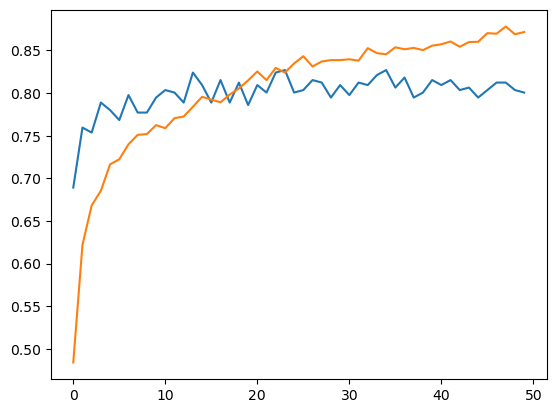

In [51]:
hist = history.history
plt.plot(hist['val_accuracy'],label = 'val')
plt.plot(hist['accuracy'],label = 'train')

#### Note:
* The best model we got is at 24th epoch which has a validation accuracy of 82.7. 
* We will now proceed to train a model on 299x299x3 sized images. We use 150 previously because to tune easily.

### Training a model on larger images

In [9]:
def create_model(input_size,learning_rate,inner_nodes,dropout_rate):
    base_model = Xception(weights = 'imagenet',input_shape = (input_size,input_size,3),include_top = False)
    base_model.trainable = False
    inputs = keras.Input(shape = (input_size,input_size,3))
    base_features = base_model(inputs,training = False)
    feature_vectors = keras.layers.GlobalAveragePooling2D()(base_features)
    optimizer = keras.optimizers.Adam(learning_rate = learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits = True)
    inner = keras.layers.Dense(inner_nodes,activation = 'relu')(feature_vectors)
    dropout = keras.layers.Dropout(dropout_rate)(inner)
    outputs = keras.layers.Dense(10)(dropout)
    model = keras.Model(inputs,outputs)
    model.compile(optimizer=optimizer,loss=loss,metrics = ['accuracy'])
    return model

In [10]:
input_size = 299
train_gen = ImageDataGenerator(preprocessing_function = preprocess_input,
                              vertical_flip = True,
                              shear_range = 10,
                              zoom_range = 0.1)
val_gen = ImageDataGenerator(preprocessing_function = preprocess_input)
test_gen = ImageDataGenerator(preprocessing_function = preprocess_input)
train_data = train_gen.flow_from_directory('clothing-dataset-small-master/train',target_size = (input_size,input_size),batch_size = 32)
val_data = val_gen.flow_from_directory('clothing-dataset-small-master/validation',target_size = (input_size,input_size),batch_size = 32,shuffle = False)
test_data = test_gen.flow_from_directory('clothing-dataset-small-master/test',target_size = (input_size,input_size),batch_size = 32,shuffle = False)

Found 3068 images belonging to 10 classes.
Found 341 images belonging to 10 classes.
Found 372 images belonging to 10 classes.


In [13]:
save_checkpoint = keras.callbacks.ModelCheckpoint('xception_v1_{epoch:02d}_{val_accuracy:.3f}',
                                                  save_best_only = True,
                                                  monitor = 'val_accuracy',
                                                  mode = 'max',
                                                  save_format = 'tf'
                                                 )

In [14]:
lr = 0.001
n = 100
r = 0.5
model = create_model(input_size = input_size,learning_rate = lr,inner_nodes = n, dropout_rate = r)
history = model.fit(train_data,epochs = 50,validation_data = val_data, callbacks = [save_checkpoint])

Epoch 1/50
96/96 [==============================] - ETA: 0s - loss: 1.3074 - accuracy: 0.5730INFO:tensorflow:Assets written to: xception_v1_01_0.774/assets


INFO:tensorflow:Assets written to: xception_v1_01_0.774/assets


96/96 [==============================] - 91s 862ms/step - loss: 1.3074 - accuracy: 0.5730 - val_loss: 0.7091 - val_accuracy: 0.7742
Epoch 2/50
96/96 [==============================] - ETA: 0s - loss: 0.8720 - accuracy: 0.7213INFO:tensorflow:Assets written to: xception_v1_02_0.818/assets


INFO:tensorflow:Assets written to: xception_v1_02_0.818/assets


96/96 [==============================] - 70s 730ms/step - loss: 0.8720 - accuracy: 0.7213 - val_loss: 0.5650 - val_accuracy: 0.8182
Epoch 3/50
96/96 [==============================] - ETA: 0s - loss: 0.7415 - accuracy: 0.7516INFO:tensorflow:Assets written to: xception_v1_03_0.827/assets


INFO:tensorflow:Assets written to: xception_v1_03_0.827/assets


96/96 [==============================] - 71s 735ms/step - loss: 0.7415 - accuracy: 0.7516 - val_loss: 0.4785 - val_accuracy: 0.8270
Epoch 4/50
96/96 [==============================] - ETA: 0s - loss: 0.6877 - accuracy: 0.7748INFO:tensorflow:Assets written to: xception_v1_04_0.836/assets


INFO:tensorflow:Assets written to: xception_v1_04_0.836/assets


96/96 [==============================] - 71s 737ms/step - loss: 0.6877 - accuracy: 0.7748 - val_loss: 0.4861 - val_accuracy: 0.8358
Epoch 5/50
96/96 [==============================] - ETA: 0s - loss: 0.6468 - accuracy: 0.7898INFO:tensorflow:Assets written to: xception_v1_05_0.845/assets


INFO:tensorflow:Assets written to: xception_v1_05_0.845/assets


96/96 [==============================] - 70s 728ms/step - loss: 0.6468 - accuracy: 0.7898 - val_loss: 0.4431 - val_accuracy: 0.8446
Epoch 6/50
96/96 [==============================] - 56s 580ms/step - loss: 0.6129 - accuracy: 0.7950 - val_loss: 0.4440 - val_accuracy: 0.8446
Epoch 7/50
96/96 [==============================] - ETA: 0s - loss: 0.5689 - accuracy: 0.8061INFO:tensorflow:Assets written to: xception_v1_07_0.856/assets


INFO:tensorflow:Assets written to: xception_v1_07_0.856/assets


96/96 [==============================] - 70s 734ms/step - loss: 0.5689 - accuracy: 0.8061 - val_loss: 0.4059 - val_accuracy: 0.8563
Epoch 8/50
96/96 [==============================] - 57s 588ms/step - loss: 0.5519 - accuracy: 0.8136 - val_loss: 0.4006 - val_accuracy: 0.8475
Epoch 9/50
96/96 [==============================] - 57s 592ms/step - loss: 0.5085 - accuracy: 0.8269 - val_loss: 0.4053 - val_accuracy: 0.8504
Epoch 10/50
96/96 [==============================] - 57s 592ms/step - loss: 0.5100 - accuracy: 0.8341 - val_loss: 0.4043 - val_accuracy: 0.8534
Epoch 11/50
96/96 [==============================] - 57s 596ms/step - loss: 0.4926 - accuracy: 0.8328 - val_loss: 0.4120 - val_accuracy: 0.8534
Epoch 12/50
96/96 [==============================] - ETA: 0s - loss: 0.4693 - accuracy: 0.8364INFO:tensorflow:Assets written to: xception_v1_12_0.859/assets


INFO:tensorflow:Assets written to: xception_v1_12_0.859/assets


96/96 [==============================] - 69s 723ms/step - loss: 0.4693 - accuracy: 0.8364 - val_loss: 0.4045 - val_accuracy: 0.8592
Epoch 13/50
96/96 [==============================] - 57s 594ms/step - loss: 0.4530 - accuracy: 0.8462 - val_loss: 0.3916 - val_accuracy: 0.8475
Epoch 14/50
96/96 [==============================] - ETA: 0s - loss: 0.4344 - accuracy: 0.8494INFO:tensorflow:Assets written to: xception_v1_14_0.862/assets


INFO:tensorflow:Assets written to: xception_v1_14_0.862/assets


96/96 [==============================] - 69s 720ms/step - loss: 0.4344 - accuracy: 0.8494 - val_loss: 0.3889 - val_accuracy: 0.8622
Epoch 15/50
96/96 [==============================] - 56s 585ms/step - loss: 0.4177 - accuracy: 0.8510 - val_loss: 0.4133 - val_accuracy: 0.8534
Epoch 16/50
96/96 [==============================] - 57s 588ms/step - loss: 0.3939 - accuracy: 0.8638 - val_loss: 0.4116 - val_accuracy: 0.8534
Epoch 17/50
96/96 [==============================] - 56s 585ms/step - loss: 0.4086 - accuracy: 0.8602 - val_loss: 0.4358 - val_accuracy: 0.8475
Epoch 18/50
96/96 [==============================] - 56s 586ms/step - loss: 0.3993 - accuracy: 0.8611 - val_loss: 0.4044 - val_accuracy: 0.8534
Epoch 19/50
96/96 [==============================] - 58s 600ms/step - loss: 0.3891 - accuracy: 0.8735 - val_loss: 0.4137 - val_accuracy: 0.8534
Epoch 20/50
96/96 [==============================] - 58s 600ms/step - loss: 0.3778 - accuracy: 0.8797 - val_loss: 0.4254 - val_accuracy: 0.8504
Epoc

INFO:tensorflow:Assets written to: xception_v1_21_0.868/assets


96/96 [==============================] - 71s 740ms/step - loss: 0.3702 - accuracy: 0.8703 - val_loss: 0.4061 - val_accuracy: 0.8680
Epoch 22/50
96/96 [==============================] - 58s 604ms/step - loss: 0.3633 - accuracy: 0.8787 - val_loss: 0.4006 - val_accuracy: 0.8592
Epoch 23/50
96/96 [==============================] - 56s 584ms/step - loss: 0.3515 - accuracy: 0.8787 - val_loss: 0.4279 - val_accuracy: 0.8475
Epoch 24/50
96/96 [==============================] - ETA: 0s - loss: 0.3620 - accuracy: 0.8742INFO:tensorflow:Assets written to: xception_v1_24_0.871/assets


INFO:tensorflow:Assets written to: xception_v1_24_0.871/assets


96/96 [==============================] - 70s 730ms/step - loss: 0.3620 - accuracy: 0.8742 - val_loss: 0.4037 - val_accuracy: 0.8710
Epoch 25/50
96/96 [==============================] - 58s 606ms/step - loss: 0.3180 - accuracy: 0.8928 - val_loss: 0.3999 - val_accuracy: 0.8680
Epoch 26/50
96/96 [==============================] - 58s 597ms/step - loss: 0.3323 - accuracy: 0.8810 - val_loss: 0.4093 - val_accuracy: 0.8504
Epoch 27/50
96/96 [==============================] - 57s 594ms/step - loss: 0.3306 - accuracy: 0.8849 - val_loss: 0.4106 - val_accuracy: 0.8475
Epoch 28/50
96/96 [==============================] - ETA: 0s - loss: 0.3069 - accuracy: 0.8973INFO:tensorflow:Assets written to: xception_v1_28_0.874/assets


INFO:tensorflow:Assets written to: xception_v1_28_0.874/assets


96/96 [==============================] - 70s 732ms/step - loss: 0.3069 - accuracy: 0.8973 - val_loss: 0.4124 - val_accuracy: 0.8739
Epoch 29/50
96/96 [==============================] - 57s 591ms/step - loss: 0.3210 - accuracy: 0.8967 - val_loss: 0.4189 - val_accuracy: 0.8680
Epoch 30/50
96/96 [==============================] - 56s 586ms/step - loss: 0.2988 - accuracy: 0.8967 - val_loss: 0.4134 - val_accuracy: 0.8710
Epoch 31/50
96/96 [==============================] - 57s 588ms/step - loss: 0.2971 - accuracy: 0.9003 - val_loss: 0.3971 - val_accuracy: 0.8710
Epoch 32/50
96/96 [==============================] - 57s 587ms/step - loss: 0.2824 - accuracy: 0.9051 - val_loss: 0.4369 - val_accuracy: 0.8680
Epoch 33/50
96/96 [==============================] - ETA: 0s - loss: 0.2841 - accuracy: 0.9032INFO:tensorflow:Assets written to: xception_v1_33_0.877/assets


INFO:tensorflow:Assets written to: xception_v1_33_0.877/assets


96/96 [==============================] - 70s 731ms/step - loss: 0.2841 - accuracy: 0.9032 - val_loss: 0.4145 - val_accuracy: 0.8768
Epoch 34/50
96/96 [==============================] - ETA: 0s - loss: 0.2908 - accuracy: 0.8977INFO:tensorflow:Assets written to: xception_v1_34_0.883/assets


INFO:tensorflow:Assets written to: xception_v1_34_0.883/assets


96/96 [==============================] - 69s 722ms/step - loss: 0.2908 - accuracy: 0.8977 - val_loss: 0.4058 - val_accuracy: 0.8827
Epoch 35/50
96/96 [==============================] - 57s 589ms/step - loss: 0.2710 - accuracy: 0.9022 - val_loss: 0.4133 - val_accuracy: 0.8680
Epoch 36/50
96/96 [==============================] - 58s 599ms/step - loss: 0.2780 - accuracy: 0.8973 - val_loss: 0.4038 - val_accuracy: 0.8622
Epoch 37/50
96/96 [==============================] - 57s 588ms/step - loss: 0.2818 - accuracy: 0.8999 - val_loss: 0.4045 - val_accuracy: 0.8739
Epoch 38/50
96/96 [==============================] - 56s 579ms/step - loss: 0.2529 - accuracy: 0.9097 - val_loss: 0.4394 - val_accuracy: 0.8651
Epoch 39/50
96/96 [==============================] - 55s 571ms/step - loss: 0.2538 - accuracy: 0.9071 - val_loss: 0.4182 - val_accuracy: 0.8768
Epoch 40/50
96/96 [==============================] - 55s 575ms/step - loss: 0.2540 - accuracy: 0.9113 - val_loss: 0.4305 - val_accuracy: 0.8592
Epoc

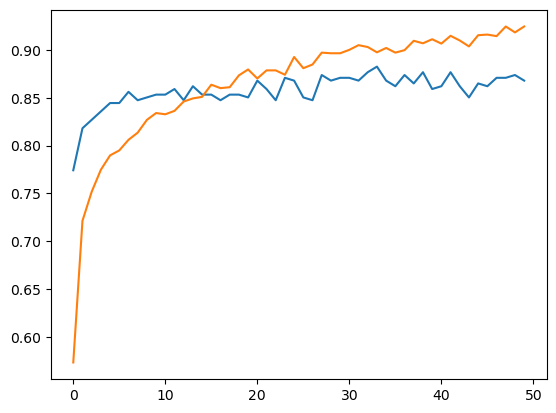

In [15]:
hist = history.history
plt.plot(hist['val_accuracy'],label = 'val')
plt.plot(hist['accuracy'],label = 'train')

##### The best model is obtained from the epoch 34 which has an accuracy of 88.3%

## Lets test the model

In [20]:
test_gen = ImageDataGenerator(preprocessing_function = preprocess_input)
test_data = test_gen.flow_from_directory('clothing-dataset-small-master/test',target_size = (299,299),batch_size = 32,shuffle = False)
loss, acc = model.evaluate(test_data)
print(f"Test accuracy: {acc:.4f}")

Found 372 images belonging to 10 classes.
12/12 [==============================] - 3s 200ms/step - loss: 0.2982 - accuracy: 0.8925
Test accuracy: 0.8925
